In [1]:
from dolfin import *
import numpy as np
# import pygad
import pyswarms as ps
import matplotlib.pyplot as plt
import mshr as mr

set_log_level(50)

vertex number: 27
cell number: 32


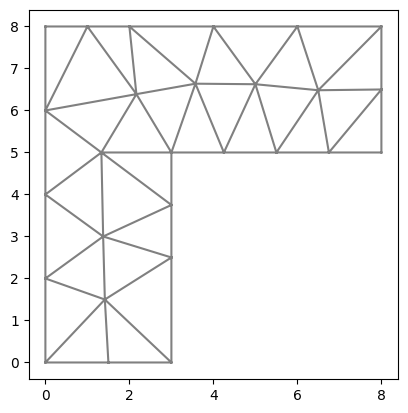

In [2]:
# 创建网格
rectangle = mr.Rectangle(Point(0.0, 0.0), Point(8.0, 8.0))
rectangle_multi = mr.Rectangle(Point(3.0, 0.0), Point(8.0, 5.0))
domain = rectangle - rectangle_multi

# 创建网格
mymesh = mr.generate_mesh(domain, 4)
vertex_num = mymesh.num_vertices()
cell_num = mymesh.num_cells()
plot(mymesh)
print(f"vertex number: {vertex_num}")
print(f"cell number: {cell_num}")

In [3]:
# 初始化
"""初始化"""
# 二维正交各向异性
E1, E2, mu12, G12 = 130000, 7700, 0.33, 4800
# 转动角度
Theta = 0
Theta_init = 5
# 载荷
forcing = Constant((0, -500))

# 弹性张量
C2D_Iso = np.array([
    [E1/(1-mu12**2),        mu12*E2/(1-mu12**2),         0  ],
    [mu12*E2/(1-mu12**2),   E2/(1-mu12**2),              0  ],
    [0,                     0,                           G12]
])

# 转轴公式
def T2D_inv(theta):
    theta = theta * np.pi / 180.0
    c = cos(theta)
    s = sin(theta)
    Trans = np.array([
        [c**2,  s**2,   -2*s*c],
        [s**2,  c**2,   2*s*c],
        [s*c,   -s*c,   c**2 - s**2]
    ])
    return Trans

# 准备网格
V = VectorFunctionSpace(mymesh, "CG", 1)
T = FunctionSpace(mymesh, "DG", 0)
u_sol = Function(V)
Theta_sol = Function(T)
u_trial = TrialFunction(V)
v_test = TestFunction(V)

In [4]:
# 定义物理方程
# 物理方程
def epsilon(u):
    engineering_strain = 0.5 * (nabla_grad(u) + nabla_grad(u).T)
    return engineering_strain

# 本构方程
def sigma_tensor(u, Theta_Ev):
    # 计算应变张量
    epsilon_ij = epsilon(u)
    ep = as_vector([epsilon_ij[0,0], epsilon_ij[1,1], epsilon_ij[0,1]])
    # 使用弹性系数计算应力张量
    Q_bar = np.dot(np.dot(T2D_inv(Theta_Ev), C2D_Iso), T2D_inv(Theta_Ev).T)
    sigma_ij = np.dot(Q_bar, ep)

    return as_tensor([[sigma_ij[0], sigma_ij[2]],
                      [sigma_ij[2], sigma_ij[1]]])

# 弹性能密度
def psi(u, Theta):
    return 0.5 * inner(sigma_tensor(u, Theta), epsilon(u))

In [5]:
# 定义边界
# 狄利克雷边界
def clamped_boundary(x, on_boundary):
    return on_boundary and x[1] < DOLFIN_EPS
bc = DirichletBC(V, Constant((0.0, 0.0)), clamped_boundary)

# 自然边界
class RightEnd(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and abs(x[0] - 8) < DOLFIN_EPS 
right_end_boundary = RightEnd()

boundary_mark = MeshFunction("size_t", mymesh, mymesh.topology().dim()-1)
boundary_mark.set_all(0)
right_end_boundary.mark(boundary_mark, 1)

In [6]:
# 有限元求解
def FEA(lhs, rhs, u:Function, bc:DirichletBC) -> Function: 
    problem = LinearVariationalProblem(lhs, rhs, u, bc)
    solver = LinearVariationalSolver(problem)
    return solver.solve()

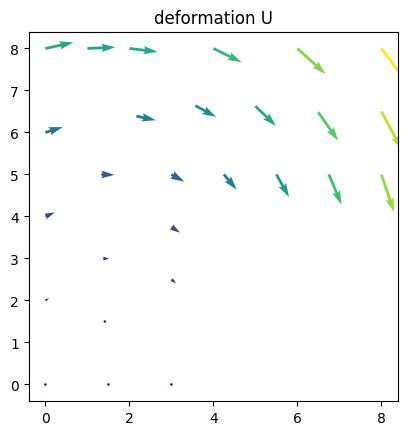

In [7]:
# 有限元计算
theta = 0 * np.ones(T.dim())
theta_init = Function(T)
theta_init.vector()[:] = theta
lhs = inner(sigma_tensor(u_trial, theta_init), nabla_grad(v_test)) * dx
rhs = dot(forcing, v_test) * ds(subdomain_data=boundary_mark, domain=mymesh, subdomain_id=1)
FEA(lhs, rhs, u_sol ,bc=[bc])
plot(u_sol, title="deformation U")

Max Principal Stress Values: [  193.73881446   560.06875919   417.79984377   206.89899904
   645.45123694   107.15828302  1511.30508678   985.27942328
   320.49959388  1935.31974933  1294.53227736 -1974.45505037
   250.92492198  3160.05418541  1012.41991468 -1695.70895133
   814.04185803   939.53370686  1608.30623559  1594.40364707
   291.77905192  1312.65380081  2645.69874149  1103.50155083
  4707.46474619  2313.66928082   967.40096081]
Max Principal Direction Values: [ 0.54875442 -0.8359836   0.78384979 -0.62095049  0.52631524 -0.85028952
  0.74906936 -0.66249158  0.8000278  -0.59996293  0.24497488 -0.96952943
  0.97956485 -0.20112858  0.88412585 -0.46724884  0.29339919 -0.95599002
  0.99991375 -0.01313367  0.98067912 -0.19562328  0.32311176 -0.94636081
  0.76971121  0.63839225  0.99190896  0.12695124  0.99957621  0.02911007
  0.99825252 -0.05909235 -0.6887158  -0.72503141 -0.09498362 -0.99547884
 -0.01949645 -0.99980993  0.99325523  0.11594846  0.99983318  0.01826512
  0.95324854  0

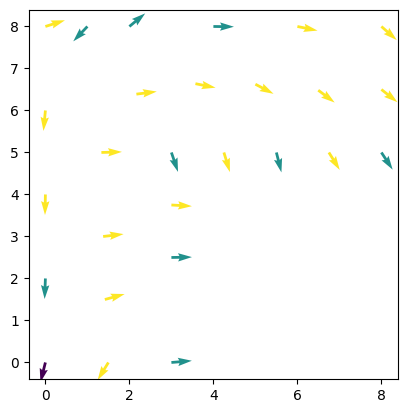

In [8]:
# 计算最大主应力场
stress = sigma_tensor(u_sol, theta_init)
# 创建一个张量函数空间来存储应力场
V_ten = TensorFunctionSpace(mymesh, 'CG', 1)
stress_func = Function(V_ten)

stress_func.assign(project(stress, V_ten))

# 定义函数空间
V_max_principal = FunctionSpace(mymesh, 'CG', 1)
V_vec = VectorFunctionSpace(mymesh, 'CG', 1)

# 定义最大主应力函数和方向函数
max_principal_stress = Function(V_max_principal)
max_principal_direction = Function(V_vec)

# 提取应力值
stress_values = stress_func.vector().get_local().reshape((-1, 2, 2))

# 获取本地向量大小
local_size_stress = max_principal_stress.vector().local_size()
local_size_direction = max_principal_direction.vector().local_size()

# 初始化最大主应力和方向数组
max_principal_stress_values = np.zeros(local_size_stress)
max_principal_direction_values = np.zeros((local_size_direction // 2, 2))  # 确保方向是2维

# 计算最大主应力和方向
for i, stress_tensor in enumerate(stress_values):
    # 计算特征值和特征向量
    eigenvalues, eigenvectors = np.linalg.eig(stress_tensor)
    max_index = np.argmax(eigenvalues)
    max_principal_stress_values[i] = eigenvalues[max_index]
    max_principal_direction_values[i] = eigenvectors[:, max_index]

# 将最大主应力值和方向赋值给相应的函数
max_principal_stress.vector().set_local(max_principal_stress_values)
max_principal_direction.vector().set_local(max_principal_direction_values.flatten())

# 打印最大主应力值和方向
print("Max Principal Stress Values:", max_principal_stress.vector().get_local())
print("Max Principal Direction Values:", max_principal_direction.vector().get_local())
plot(max_principal_direction)

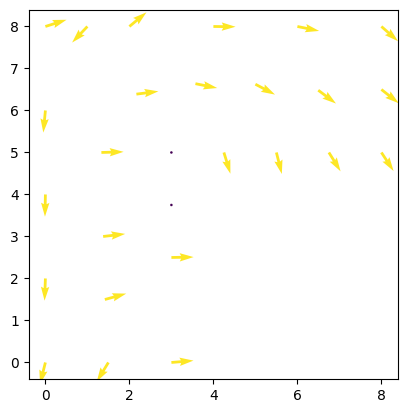

In [9]:
# 计算拉应力场和压应力场
stress = sigma_tensor(u_sol, theta_init)

# 创建一个张量函数空间来存储应力场
V_ten = TensorFunctionSpace(mymesh, 'CG', 1)
stress_func = Function(V_ten)

stress_func.assign(project(stress, V_ten))

# 定义函数空间
V_scalar = FunctionSpace(mymesh, 'CG', 1)
V_vec = VectorFunctionSpace(mymesh, 'CG', 1)

# 定义拉应力和压应力函数及其方向函数
tensile_stress = Function(V_scalar)
compressive_stress = Function(V_scalar)
tensile_direction = Function(V_vec)
compressive_direction = Function(V_vec)

# 提取应力值
stress_values = stress_func.vector().get_local().reshape((-1, 2, 2))

# 获取本地向量大小
local_size_stress = tensile_stress.vector().local_size()
local_size_direction = tensile_direction.vector().local_size()

# 初始化拉应力和压应力及其方向数组
tensile_stress_values = np.zeros(local_size_stress)
compressive_stress_values = np.zeros(local_size_stress)
tensile_direction_values = np.zeros((local_size_direction // 2, 2))  # 确保方向是2维
compressive_direction_values = np.zeros((local_size_direction // 2, 2))  # 确保方向是2维

# 计算拉应力和压应力及其方向
for i, stress_tensor in enumerate(stress_values):
    # 计算特征值和特征向量
    eigenvalues, eigenvectors = np.linalg.eig(stress_tensor)
    
    # 分别获取拉应力和压应力及其方向
    tensile_eigenvalues = eigenvalues[eigenvalues > 0]
    compressive_eigenvalues = eigenvalues[eigenvalues < 0]
    
    if len(tensile_eigenvalues) > 0:
        max_tensile_index = np.argmax(tensile_eigenvalues)
        tensile_stress_values[i] = tensile_eigenvalues[max_tensile_index]
        tensile_direction_values[i] = eigenvectors[:, eigenvalues == tensile_eigenvalues[max_tensile_index]].flatten()
    else:
        tensile_stress_values[i] = 0
        tensile_direction_values[i] = [0, 0]
    
    if len(compressive_eigenvalues) > 0:
        max_compressive_index = np.argmin(compressive_eigenvalues)
        compressive_stress_values[i] = compressive_eigenvalues[max_compressive_index]
        compressive_direction_values[i] = eigenvectors[:, eigenvalues == compressive_eigenvalues[max_compressive_index]].flatten()
    else:
        compressive_stress_values[i] = 0
        compressive_direction_values[i] = [0, 0]

# 将拉应力和压应力值及其方向赋值给相应的函数
tensile_stress.vector().set_local(tensile_stress_values)
compressive_stress.vector().set_local(compressive_stress_values)
tensile_direction.vector().set_local(tensile_direction_values.flatten())
compressive_direction.vector().set_local(compressive_direction_values.flatten())

# 绘制拉应力方向场
plot(tensile_direction)
# 绘制压应力方向场
# plot(compressive_direction)

In [10]:
# 可视化
def plot_theta_vector(theta:Function, mesh, scale=30, width=0.001):
    theta_rad = np.deg2rad(Theta_sol.vector()[:])  # 将角度转换为弧度
    x_values = np.cos(theta_rad)
    y_values = np.sin(theta_rad)
    # 将二维向量表示合并为一个二维数组
    vector_values = np.vstack((x_values, y_values)).T  # 转置使每行是一个向量
    # 获取网格的中心点
    cell_midpoints = [cell.midpoint() for cell in cells(mesh)]
    # 提取中心点的坐标
    x_coords = np.array([p.x() for p in cell_midpoints])
    y_coords = np.array([p.y() for p in cell_midpoints])
    u = vector_values[:, 0]
    v = vector_values[:, 1]
    # 可视化向量场
    plt.figure()
    # plot(mesh)
    # plt.quiver(x_coords, y_coords, u, v)
    # 绘制正方向的箭头
    plt.quiver(x_coords, y_coords, u, v, angles='xy', scale_units='xy', scale=scale, width=width, color='b')
    # 绘制反方向的箭头
    # plt.quiver(x_coords, y_coords, -u, -v, angles='xy', scale_units='xy', scale=scale, width=width, color='b')

    plt.title("Vector field")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.axis("equal")
    plt.show()

In [11]:
# theta_values = x[:, :T.dim()]
# theta_values = 45 * np.ones(T.dim())
# print(theta_values)

In [12]:
# 定义优化问题
def minimize_strain_energy(x):
    # 将 PSO 粒子的位置 x 映射到每个单元格的转动角度
    theta_values = x[:, :T.dim()]
    # theta_values = 45 * np.ones((x.shape[0], T.dim())

    total_energy = []
    for i in range(theta_values.shape[0]):
        theta_func = Function(T)
        theta_func.vector()[:] = theta_values[i, :]
        Theta_sol.assign(theta_func)
        lhs = inner(sigma_tensor(u_trial, Theta_sol), nabla_grad(v_test)) * dx
        rhs = dot(forcing, v_test) * ds(subdomain_data=boundary_mark, domain=mymesh, subdomain_id=1)
        FEA(lhs, rhs, u_sol, bc)
        energy_density = assemble(psi(u_sol, Theta_sol) * dx)
        total_energy.append(energy_density)


        # psi_values = psi(u_sol, Theta_sol)
        # # 将 psi_values 投影到函数空间中
        # psi_projected = project(psi_values, T)
        # # 将 psi_projected 的值提取为 numpy 数组
        # psi_array = psi_projected.vector().get_local()
        # # 找到数组中的最大值
        # max_psi_value = np.max(psi_array)
        # total_energy = max_psi_value


    return np.array(total_energy)

# Set-up hyperparameters
options = {'c1': 0.5, 'c2': 0.3, 'w':0.9}

# Define initial positions for particles
init_pos = np.random.uniform(low=45, high=45, size=(50, T.dim()))

# Call instance of PSO
optimizer = ps.single.GlobalBestPSO(n_particles=50, dimensions=T.dim(), options=options, init_pos=init_pos)

# Perform optimization
cost, pos = optimizer.optimize(minimize_strain_energy, iters=5000)


2024-08-07 20:58:26,408 - pyswarms.single.global_best - INFO - Optimize for 5000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|5000/5000, best_cost=1.84e+3
2024-08-07 21:25:52,265 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1843.1183852852378, best pos: [ 48.00044006  85.71509594  38.92699718  54.64248969  54.13691216
  40.41066869  75.78134997  47.46163552  56.20462816  45.68342367
  58.4662087  -15.14931161  40.92813449  64.7047064   51.00764011
  38.12295646  43.93810153  61.44463873  29.64291766  42.36570817
  78.8862392   52.96108533  52.5446899   52.93471503  58.96597167
  43.61432841  46.2151493   50.68722234  44.17090477  50.76149232
  54.25123651  70.22957601]


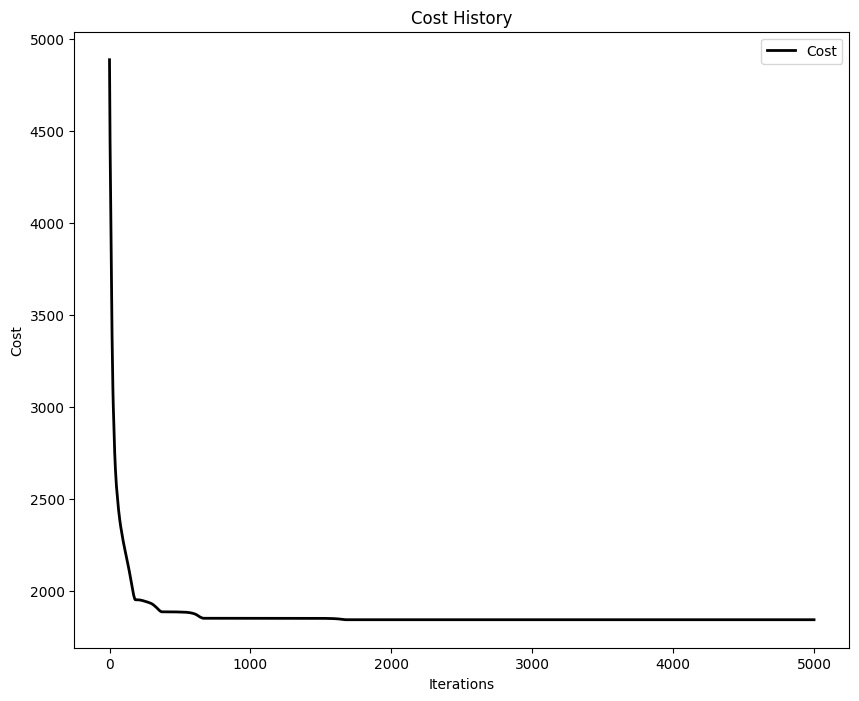

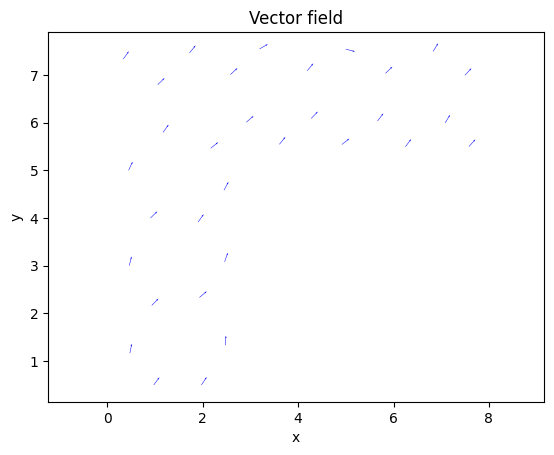

In [13]:
# 可视化
import matplotlib.pyplot as plt
from pyswarms.utils.plotters import (plot_cost_history, plot_contour, plot_surface)

plot_cost_history(cost_history=optimizer.cost_history)
plt.show()

Theta_sol.vector()[:] = pos
plot_theta_vector(Theta_sol, mesh=mymesh, scale=5, width=0.001)

plt.show()

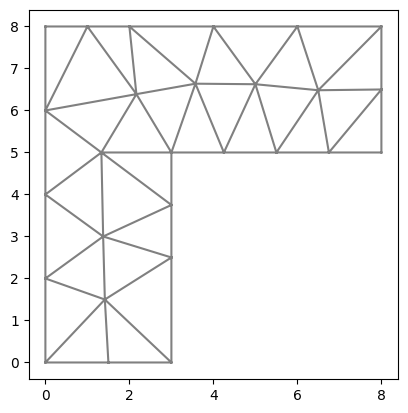

In [14]:
plot(mymesh)